<a href="https://colab.research.google.com/github/raffieeey/MasterResearchAutoML/blob/master/tpot/freedom/03A_TPOT_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install numpy scipy scikit-learn pandas joblib
!pip install deap update_checker tqdm stopit
!pip install xgboost
!pip install dask[delayed] dask-ml
!pip install scikit-mdr skrebate
!pip install tpot
!pip install pmlb
!pip install pytictoc

In [6]:
%matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np



def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate","True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate","True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall","Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = (np.sum(labels)/len(labels))[0]
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall","Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

figure()

<Figure size 648x324 with 0 Axes>

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss
import numpy as np
import pandas as pd


class CheckBinomial:
  def __init__(self, checkunique):
    self._bintype = 'binomial' if pd.Series(checkunique).nunique() == 2 else 'multinomial'

  def MLMetrics(self):
    if self._bintype == 'binomial':
      return ['accuracy', 'roc_auc', 'neg_log_loss']
    elif self._bintype == 'multinomial':
      return ['accuracy', 'neg_log_loss']

class MetricsCalc:
  def __init__(self, truth, predictions, probab, dattype):
    self.truth = truth
    self.predictions = predictions
    self._target = predictions
    self._probabmax = np.max(probab, axis=1)
    self._probab = probab
    self._type = dattype

  def acc(self):
    return float(accuracy_score(self.truth,self._target))

  def auc(self):
    if self._type == "binomial":
      return float(roc_auc_score(self.truth, self._probabmax))
    elif self._type == "multinomial":
      return np.nan 

  def logloss(self):
    return float(log_loss(self.truth, self._probab))
  
  def cm(self):
    return confusion_matrix(self.truth, self._target)
  
  def f1(self):
    if self._type == "binomial":
      return float(f1_score(self.truth, self._target, average='binary'))
    elif self._type == "multinomial":
      return float(f1_score(self.truth, self._target, average='macro'))

________________________________________________________________________________
*** Dataset Name: adult ***
Elapsed time is 1947.228389 seconds.
*** Top algorithm: *** GradientBoostingClassifier(max_depth=6, max_features=0.7500000000000001,
                           min_samples_leaf=19, min_samples_split=6,
                           random_state=69, subsample=0.8)


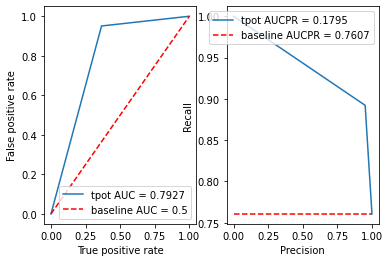

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Elapsed time is 1800.592325 seconds.
*** Top algorithm: *** KNeighborsClassifier(n_neighbors=3, p=1)


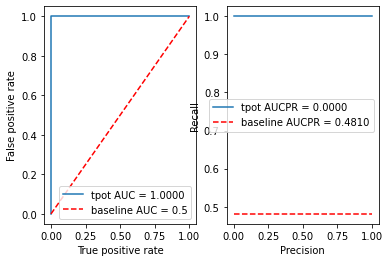

________________________________________________________________________________
*** Dataset Name: churn ***
Elapsed time is 1832.255078 seconds.
*** Top algorithm: *** ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_features=1.0,
                     min_samples_leaf=5, min_samples_split=8, random_state=69)


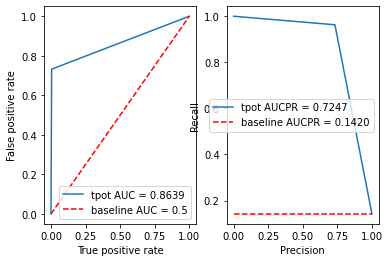

________________________________________________________________________________
*** Dataset Name: nursery ***
Elapsed time is 1841.682656 seconds.
*** Top algorithm: *** XGBClassifier(learning_rate=1.0, max_depth=6, min_child_weight=5, nthread=1,
              objective='multi:softprob', random_state=69,
              subsample=0.6500000000000001)
________________________________________________________________________________
*** Dataset Name: satimage ***
Elapsed time is 1941.319076 seconds.
*** Top algorithm: *** XGBClassifier(learning_rate=0.5, max_depth=10, nthread=1,
              objective='multi:softprob', random_state=69,
              subsample=0.7000000000000001)
________________________________________________________________________________
*** Dataset Name: texture ***
Elapsed time is 1818.097945 seconds.
*** Top algorithm: *** LinearSVC(C=5.0, random_state=69)


RuntimeError: ignored

In [8]:
from pmlb import classification_dataset_names, regression_dataset_names,fetch_data
from tpot import TPOTClassifier, TPOTRegressor
from sklearn.model_selection import train_test_split
from pytictoc import TicToc
import pandas as pd

df_result = pd.DataFrame(columns=["dataset_name", "metrics_recorded", "AUC", "ACC","logloss", "f1_score"])

preds = {}
preds_prob = {}
cm_preds = {}
top_algo = {}
t = TicToc()


sel_clss_dtst = ['adult','agaricus-lepiota', 'churn', 'nursery', 'satimage','texture']
sel_rgrs_dtst = ['294_satellite_image','218_house_8L', '227_cpu_small', '503_wind', '344_mv','215_2dplanes']

ix = 0

for class_dtst in sel_clss_dtst:
  for metrics_test in ['accuracy']:
        print("_"*80)
        print(f"*** Dataset Name: {class_dtst} ***")
        df_result.loc[ix,"dataset_name"] = class_dtst
        df_result.loc[ix,"metrics_recorded"] = metrics_test
        X, y = fetch_data(class_dtst, return_X_y=True)
        c=CheckBinomial(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69, stratify=y)
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
        y_train = pd.DataFrame(y_train).values.ravel()
        y_test = pd.DataFrame(y_test).values.ravel()
        list_metrics = c.MLMetrics()
        tpot = TPOTClassifier(random_state=69, max_time_mins=30, n_jobs=4,  scoring=metrics_test if metrics_test in list_metrics else None)
        t.tic()
        tpot.fit(X_train,y_train)
        t.toc()
        top_algo[class_dtst] = [v[0] for i, v in tpot.pareto_front_fitted_pipelines_.items()][0]
        print("*** Top algorithm: ***", [v[0] for i, v in tpot.pareto_front_fitted_pipelines_.items()][0])
        preds[class_dtst] = tpot.predict(X_test)
        preds_prob[class_dtst] = tpot.predict_proba(X_test)
        p = MetricsCalc(y_test,preds[class_dtst], preds_prob[class_dtst], c._bintype )
        if c._bintype == "binomial":
          df_result.loc[ix,"AUC"] = p.auc()
          df_result.loc[ix,"ACC"] = p.acc()
          df_result.loc[ix,"logloss"] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          df_result.loc[ix,"f1_score"] = p.f1()
          prediction_summary( pd.DataFrame(y_test), preds[class_dtst], "tpot")
          ix+=1
        elif c._bintype == "multinomial":
          df_result.loc[ix,"AUC"] = p.auc()
          df_result.loc[ix,"ACC"] = p.acc()
          df_result.loc[ix,"logloss"] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          df_result.loc[ix,"f1_score"] = p.f1()
          ix+=1

In [0]:
for i, val in enumerate(preds):
  print(preds[val])

In [0]:
for i, val in enumerate(preds):
  pd.DataFrame(preds[val]).to_csv(f"{val}.csv")

In [9]:
df_result

,dataset_name,metrics_recorded,AUC,ACC,logloss,f1_score
0,adult,accuracy,0.724808,0.875128,0.278358,0.920532
1,agaricus-lepiota,accuracy,0.5,1,9.99201e-16,1
2,churn,accuracy,0.249647,0.958,0.161309,0.832
3,nursery,accuracy,NaN,1,0.0074406,1
4,satimage,accuracy,NaN,0.934783,0.660941,0.921074
5,texture,accuracy,NaN,NaN,NaN,NaN


In [0]:
import pprint
pprint.pprint(cm_preds)

In [10]:
top_algo

{'adult': GradientBoostingClassifier(max_depth=6, max_features=0.7500000000000001,
                            min_samples_leaf=19, min_samples_split=6,
                            random_state=69, subsample=0.8),
 'agaricus-lepiota': KNeighborsClassifier(n_neighbors=3, p=1),
 'churn': ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_features=1.0,
                      min_samples_leaf=5, min_samples_split=8, random_state=69),
 'nursery': XGBClassifier(learning_rate=1.0, max_depth=6, min_child_weight=5, nthread=1,
               objective='multi:softprob', random_state=69,
               subsample=0.6500000000000001),
 'satimage': XGBClassifier(learning_rate=0.5, max_depth=10, nthread=1,
               objective='multi:softprob', random_state=69,
               subsample=0.7000000000000001),
 'texture': LinearSVC(C=5.0, random_state=69)}

In [0]:
from google.colab import files
df_result.to_csv("data_2.csv")
#files.download('data_2.csv')



with open('data_2.txt', 'w') as f:
    f.write(str(top_algo))

#files.download('data_2.txt')